# データ集合の拡張（CIFAR10を用いた物体認識）

---
## 目的
畳み込みニューラルネットワーク (Convolutional Neural Network; CNN) を用いてCIFAR10データセットに対する物体認識を行う．
その際，データ集合の拡張（Data Augmentation）を行うことで認識性能がどのように変化するかを確認する．

## 対応するチャプター
* 7.4: データ集合の拡張
* 8.1.3: バッチアルゴリズムとミニバッチアルゴリズム
* 8.3.1: 確率的勾配降下法
* 9.1: 畳み込み処理
* 9.3: プーリング

## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [1]:
from time import time
import numpy as np

import torch
import torch.nn as nn

from torchvision.datasets import CIFAR10
from torchvision import transforms

import matplotlib.pyplot as plt

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [2]:
# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込み
CIFAR10データセットを読み込みます．

In [3]:
train_data = CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)
test_data = CIFAR10(root="./", train=False, transform=transforms.ToTensor(), download=True)

print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()


## ネットワークモデルの定義
畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層2層，全結合層3層から構成されるネットワークとします．
以前の演習と同じネットワーク構造のため，詳細は割愛します．

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8 * 8 * 32, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

---
## 画像変換によるAugmentation

Data Augmentationのための関数を作成します．


PyTorchでは，代表的な画像処理（画像変換）によるData Augmentationは，torchvision.transformsとして利用することが可能です．
このノートブックでは以下の4つを使用します．

* ColorJitter: コントラストや明るさ，色調の変換
* RandomCrop: 画像の矩形をランダムに切り取り
* RandomHorizontalFlip: 画像をランダムに左右反転
* RandomRotation: 画像をランダムに回転

また，上記の画像変換に加えて，配列データの正規化と前処理を行うための`ToTensor`を使用します．
* ToTensor: 画像データをPyTorchのTensorオブジェクトへ変換（Augmentationでは無いことに注意）


### 画像変換の可視化

まず，4つの画像変換がどのような変換を行うかを可視化して確認します．


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<Figure size 432x288 with 0 Axes>

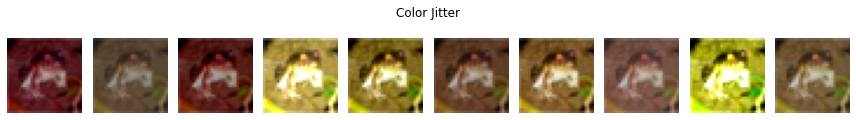

<Figure size 432x288 with 0 Axes>

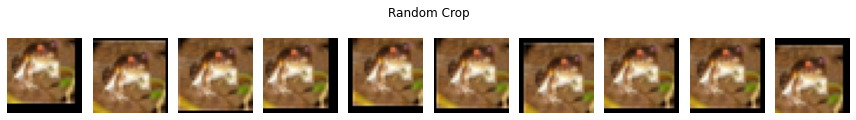

<Figure size 432x288 with 0 Axes>

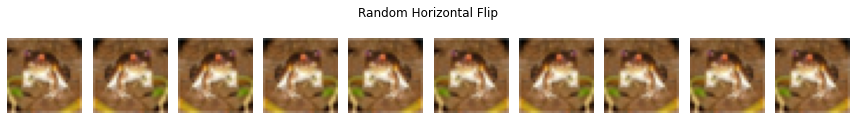

<Figure size 432x288 with 0 Axes>

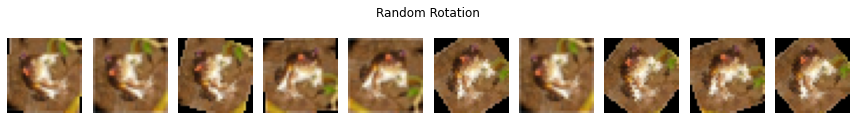

In [5]:
data_vis_coljitter = CIFAR10(root="./", train=True, transform=transforms.ColorJitter(brightness=0.5, contrast=0.4, hue=0.1), download=True)
data_vis_crop = CIFAR10(root="./", train=True, transform=transforms.RandomCrop(32, padding=4), download=True)
data_vis_flip = CIFAR10(root="./", train=True, transform=transforms.RandomHorizontalFlip(), download=True)
data_vis_rotate = CIFAR10(root="./", train=True, transform=transforms.RandomRotation(degrees=(0, 90)), download=True)


# Color Jitterによる変換例
plt.clf()
fig = plt.figure(figsize=(12, 2.0))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(data_vis_coljitter[0][0])
    ax.set_axis_off()
fig.suptitle("Color Jitter")
plt.tight_layout()
plt.show()

# RandomCropによる変換例
plt.clf()
fig = plt.figure(figsize=(12, 2.0))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(data_vis_crop[0][0])
    ax.set_axis_off()
fig.suptitle("Random Crop")
plt.tight_layout()
plt.show()

# Random Horizontal Flipによる変換例
plt.clf()
fig = plt.figure(figsize=(12, 2.0))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(data_vis_flip[0][0])
    ax.set_axis_off()
fig.suptitle("Random Horizontal Flip")
plt.tight_layout()
plt.show()

# Random Rotationによる変換例
plt.clf()
fig = plt.figure(figsize=(12, 2.0))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(data_vis_rotate[0][0])
    ax.set_axis_off()
fig.suptitle("Random Rotation")
plt.tight_layout()
plt.show()

### Composeを用いた複数の変換の組み合わせ

上記で試した画像変換を用いて，学習データに対してAugmentationを適用します．
このとき，`transforms.Compose`を使用することで，複数の処理を連続して処理して画像データを返すことが可能となります．
Composeの引数として，処理を行いたい変換のクラスをリスト内に定義します．

これらの処理をリストに定義し，Composeクラスへ与えることで，定義した処理をランダムに適用したデータを返すことが可能となります．

In [6]:
transform_train = transforms.Compose([transforms.ColorJitter(brightness=0.5, contrast=0.4, hue=0.3),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees=(0, 90)),
                                      transforms.ToTensor()])

### 学習

上記で定義したData Augmentationを用いて学習を行います．

Data Augmentaionを適用するために，CIFAR10データセットを読み込む際に，`transform_transformtrain`の引数に上で定義したComposeを設定します．
このようにすることで，データの読み出し時に自動的に画像変換を行いデータを呼び出すことが可能となります．

In [ ]:
# ネットワークモデル・最適化手法の設定
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_data = CIFAR10(root="./", train=True, transform=transform_train, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        y = model(image)

        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))

Files already downloaded and verified


### テスト
学習したネットワークモデルを用いて評価を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

---
## RandomErasingによるAugmentation

その他のAugmentationとして，Random Erasing [1] があります．

Random Erasingは，画像の一部にランダムに矩形を設定しマスク処理を行うData Augmentationです．

RandomErasingもtorchvision.transformsに実装されていますので，これを使用してその効果を確認します．

![](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/143078/02489e6c-9489-4e69-c7c1-7a02bf341c08.png)

### Random Erasingを適用した画像の可視化

Random Erasingを適用した結果を可視化し，その効果を確認します．

torchvisionに実装されているRandomErasingでは，torch.Tensor型の配列データに対する処理のみをサポートしています．
そのため，Composeを使用し，ToTensorでTensor型配列に変換したのちにRandomErasingを適用する順番で定義します．


In [ ]:
transform_erasing = transforms.Compose([transforms.ToTensor(),
                                        transforms.RandomErasing()])
data_vis_erasing = CIFAR10(root="./", train=True, transform=transform_erasing, download=True)

# Random Erasingによる変換例
plt.clf()
fig = plt.figure(figsize=(12, 2.0))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(data_vis_erasing[0][0].permute(1, 2, 0))
    ax.set_axis_off()
fig.suptitle("Random Erasing")
plt.tight_layout()
plt.show()

### 学習

RandomErasing（`transform_erasing`）を用いてネットワークの学習を行います．

In [ ]:
# ネットワークモデル・最適化手法の設定
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_data = CIFAR10(root="./", train=True, transform=transform_erasing, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        y = model(image)

        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))

### テスト

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

---
## MixupによるAugmentation

その他の近年提案された効果的なAugmentation手法として，Mixup [2] があります．

Mixupは二つの画像とそのラベル$(x_i, y_i), (x_j, y_j)$を下の式に従い，一定の比率で設計保管することで，中間的なデータを作成する手法です．


$$\tilde{x} = \lambda x_i + (1 - \lambda) x_j$$
$$\tilde{y} = \lambda y_i + (1 - \lambda) y_j$$


![](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/143078/048f8b50-f277-7b60-e16b-99c67ae19873.png)

### Mixupを適用した画像の可視化

Mixupを適用した結果を可視化し，その効果を確認します．

学習データセット `train_data` とデータローダー `train_loader` を用意し，ランダムに学習用画像を10枚サンプリングします．
その後，得られた10枚の画像の組み合わせをランダムに決定し，混合比率 `lam` に従って2枚の画像から中間的な画像を生成します．
通常は比率をベータ分布に従い決定しますが，今回は目視で確認することができるよう，`lam = 0.5` に固定し，可視化を行います．

結果より，2枚の画像が混合されたデータが作成できていることがわかります．

In [ ]:
train_data = CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for image, label in train_loader:
    # mix up -------------------------------------------
    b = image.size(0)
    
    # 比率を0.5で固定（可視化用）
    lam = 0.5
    # ベータ分布に従って比率をサンプリングする場合
    # lam = np.random.beta(1, 1)
        
    rand_idx = torch.randperm(b)
    image_rand = image[rand_idx]
    mixed_image = lam * image + (1 - lam) * image_rand
        
    onehot = torch.eye(10)[label]
    onehot_rand = onehot[rand_idx]
    mixed_label = lam * onehot + (1 - lam) * onehot_rand
    # --------------------------------------------------

    # Mixupによる変換例
    plt.clf()
    fig = plt.figure(figsize=(12, 2.0))
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        ax.imshow(image[i].permute(1, 2, 0))
        ax.set_axis_off()        
    fig.suptitle("image 1")
    plt.tight_layout()
    plt.show()

    plt.clf()
    fig = plt.figure(figsize=(12, 2.0))
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        ax.imshow(image_rand[i].permute(1, 2, 0))
        ax.set_axis_off()        
    fig.suptitle("image 2")
    plt.tight_layout()
    plt.show()

    plt.clf()
    fig = plt.figure(figsize=(12, 2.0))
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        ax.imshow(mixed_image[i].permute(1, 2, 0))
        ax.set_axis_off()        
    fig.suptitle("Mixup")
    plt.tight_layout()
    plt.show()

    break

### 学習

Mixupを用いてネットワークの学習を行います．

まず，ベータ分布からmixupの割合`lam`をサンプリングし決定します．

そして，ミニバッチのサンプルを読み込んだのちに，ミニバッチ内の画像データの順番をランダムに入れ替えた`image_rand`を作成し，元の順番のミニバッチとの重みつき和を計算することでデータのmixupを行います．

また，教師ラベルに対しても同様の処理を行います．
この時，ラベルを一度one-hotベクトル表現のラベルに変換したのちに，そのベクトルの重みつき和を求めることで，ラベルのmixupをおこんばいます．

lossの計算時は，クラスインデックスを引数に与える通常のクロスエントロピー誤差（`nn.CrossEntropyLoss()`）を使用することができないため，ネットワークの出力とベクトル表現のラベルからクロスエントロピーを手動で計算します．

In [ ]:
# ネットワークモデル・最適化手法の設定
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_data = CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        # mix up -------------------------------------------
        b = image.size(0)
        lam = np.random.beta(1, 1)
            
        rand_idx = torch.randperm(b)
        image_rand = image[rand_idx]
        mixed_image = lam * image + (1 - lam) * image_rand
            
        onehot = torch.eye(10)[label]
        onehot_rand = onehot[rand_idx]
        mixed_label = lam * onehot + (1 - lam) * onehot_rand
        # --------------------------------------------------
        
        if use_cuda:
            mixed_image = mixed_image.cuda()
            mixed_label = mixed_label.cuda()
        
        y = model(mixed_image)
    
        b, c = y.shape
        log_softmax = torch.log_softmax(y, dim=1)
        loss = - torch.sum(mixed_label * log_softmax) / b
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
    print("epoch: {}, mean loss: {}, elapsed_time :{}".format(epoch, sum_loss / n_iter, time() - start))

### テスト

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

## 課題
1. 使用するAugmentationを変更して精度の変化を確認しましょう

## 参考文献
1. Z. Zhong, et al., "Random Erasing Data Augmentation," in AAAI, 2020.
2. H. Zhang, et al., "mixup: BEYOND EMPIRICAL RISK MINIMIZATION," in ICLR, 2018.